In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import PcmPy as pcm
import warnings
import os
from sympy import sqrt

## Partial and semi-partial correlations to estimate unique variance explained by a variable in a regression model 
We consider $y$ and regressors $x_1$ and $x_2$ in the bivariate linear regression model. 

The results are completely dependent on the three correlation between the variables: 
$r_{12}=corr(x_1,x_2)$
$r_{y1}=corr(x_1,y)$, and $r_{y2}=corr(x_2,y)$.

### Partial correlation
The partial correlation between $y$ and $x_1$ controlling for $x_2$ is defined as the correlation between the residuals of $y$ and $x_1$ after regressing both on $x_2$.

Analytically, it can be computed as:
$$r_{y,1|2} = \frac{r_{y1} - r_{y2} r_{12}}{\sqrt{(1 - r_{y2}^2)(1 - r_{12}^2)}}$$

### Semi-partial correlation
The semi-partial correlation between $y$ and $x_1$ controlling for $x_2$ is defined as the correlation between $y$ and the residuals of $x_1$ after regressing $x_1$ on $x_2$.

Analytically, it can be computed as:
$$r_{y,(1|2)} = \frac{r_{y1} - r_{y2} r_{12}}{\sqrt{(1 - r_{12}^2)}}$$

### Regression coefficients in multiple regression and their relation to partial and semi-partial correlations
In a multiple regression model with $y$ as the dependent variable and $x_1$ and $x_2$ as independent variables, the regression coefficients $\beta_1$ and $\beta_2$ are simply scaled version of the semi-partial correlations.
The regression coefficient $\beta_1$ for $x_1$ can be expressed as:
$$\beta_1 = r_{y,(1|2)} \cdot \frac{\sigma_y}{\sigma_{x_1}}$$
where $\sigma_y$ is the standard deviation of $y$ and $\sigma_{x_1}$ is the standard deviation of $x_1$.        

In [2]:
from sympy import sqrt
# We can only have combinations of the three correlations, for which
# the determinant is non-negative.
ry1,ry2,r12=sym.symbols('ry1,ry2,r12')
F = sym.Matrix([[1, ry1, ry2],[ry1,1,r12],[ry2,r12,1]])
F.det()


-r12**2 + 2*r12*ry1*ry2 - ry1**2 - ry2**2 + 1

In [3]:
# What is R2 for the full model?
# First determine inv(X'X)
XX = sym.Matrix([[1, r12],[r12,1]])
XY = sym.Matrix([[ry1, ry2]])
XX.inv()

Matrix([
[   1/(1 - r12**2), -r12/(1 - r12**2)],
[-r12/(1 - r12**2),    1/(1 - r12**2)]])

In [4]:
# Now get the Regression coefficients
XX.inv() @ XY.T

Matrix([
[-r12*ry2/(1 - r12**2) + ry1/(1 - r12**2)],
[-r12*ry1/(1 - r12**2) + ry2/(1 - r12**2)]])

## Estimating unique variation  
We compare the variance partitioning method and the square semi-partial correlation as estimates of unique variance explained by a variable in a regression model.

In [5]:
def determinant(r_y1, r_y2, r12):
    """
    Calculate the determinant of the correlation matrix

    Args:
        r_y1 (float) : Correlation of first predictor with the dependent variable
        r_y2 (float) : Correlation of second predictor with the dependent variable
        r12 (float) : Correlation between the two predictors

    Returns:
        det (float) : Determinant of the 3x3 correlation matrix

    """
    DET = 1 - r_y1**2 - r_y2**2 - r12**2 + 2 * r_y1 * r_y2 * r12
    return DET

def unique_variance_partitioning(r_y1, r_y2, r12):
    """
    Estimate unique variation for X1 from variance partitioning

    Args:
        r_y1 (float) : Correlation of first predictor with the dependent variable
        r_y2 (float) : Correlation of second predictor with the dependent variable
        r12 (float) : Correlation between the two predictors

    Returns:
        unique_variance (float) : Unique variance explained by the first predictor

    """
    # R2 of the joint model:
    RY12 = (2 * r_y1 * r_y2 * r12 - r_y1**2 - r_y2**2) / (r12**2 - 1)
    shared_variance = r_y1**2 + r_y2**2 - RY12
    unique_variance = RY12 - r_y2**2
    return unique_variance

def unique_variance_semipartial(r_y1, r_y2, r12):
    """
    Estimate unique variation for X1 from semi-partial correlation

    Args:
        r_y1 (float) : Correlation of first predictor with the dependent variable
        r_y2 (float) : Correlation of second predictor with the dependent variable
        r12 (float) : Correlation between the two predictors

    Returns:
        unique_variance (float) : Unique variance explained by the first predictor

    """
    # R2 of the joint model:
    unique_variance = (r_y1 - r_y2 * r12)**2  / (1 - r12**2)
    return unique_variance


In [6]:
# Contour plot function

def bivariate_regression_contour(function,scale=[-1,1],fig=None):
    if fig is None:
        fig = plt.figure(figsize=(16, 5))
    RY1, RY2 = np.meshgrid(np.linspace(-1,1,40),np.linspace(-1,1,40))
    R12 = np.linspace(-0.9,0.9,11)
    # to be plotted value
    value = np.zeros((len(R12),RY1.shape[0],RY1.shape[1]))
    for i,r12 in enumerate(R12):
        RY1g2 = function(RY1, RY2, r12)
        DET = determinant(RY1, RY2, r12)
        RY1g2[DET<0] = np.nan # Kill stuff outside the ellipse
        ax = plt.subplot(2,6,i+1)
        value[i] = RY1g2
        plt.contourf(RY1,RY2,value[i],levels=[-1,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,1],cmap='bwr')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    return value

### Occurance of suppression and redundancy
Look at suppression (negative values) and redundancy (positive values) across the entire volume of the correlations space
We see that suppression is as prevalent as redundancy. 

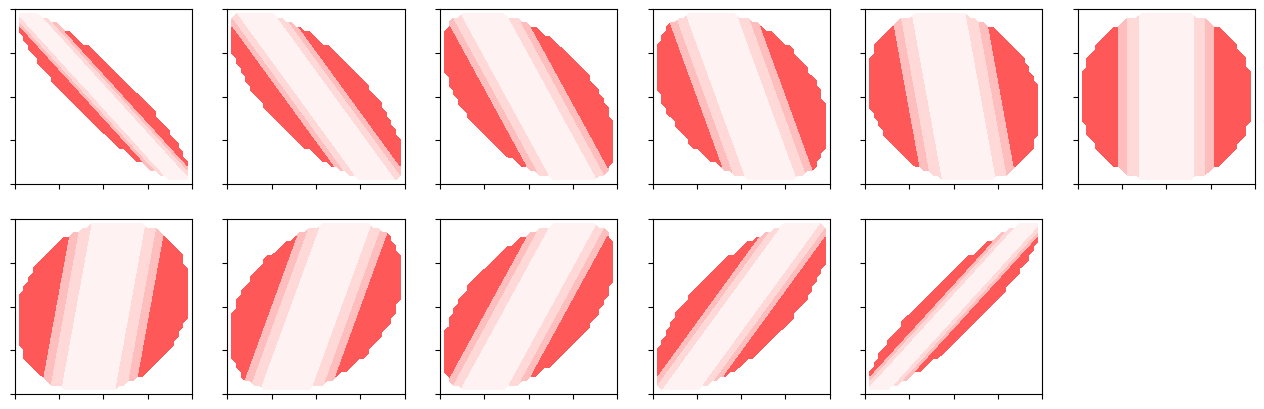

In [7]:
val1=bivariate_regression_contour(unique_variance_partitioning)

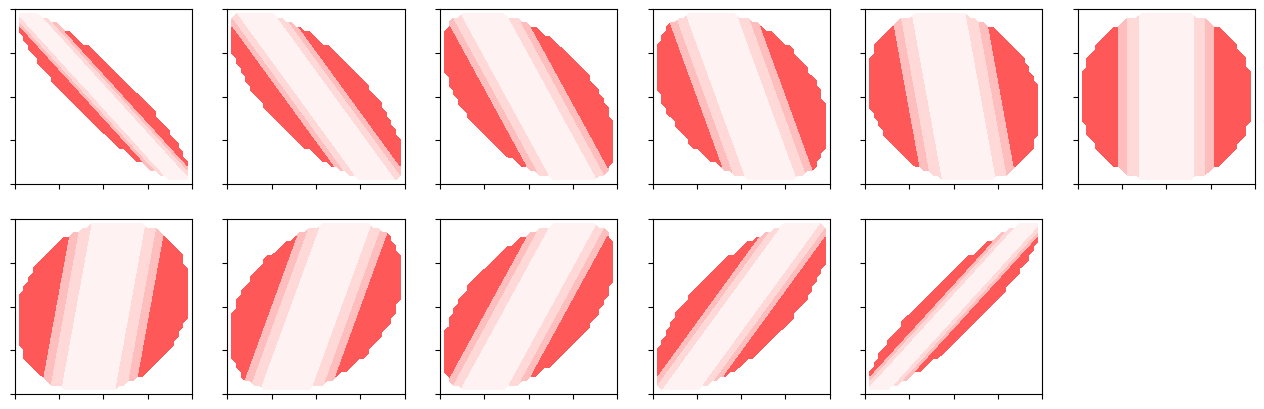

In [8]:
val2=bivariate_regression_contour(unique_variance_semipartial)